In [4]:
import sys
sys.path.append("..")
from common_utils import set_data_home
set_data_home("/mnt/d")
from common_utils import DATA_HOME, join
from lstm.sales_data import Sales_Dataset
from torch.utils.data.dataloader import DataLoader
import torch

In [5]:
SALE_HOME = join(DATA_HOME, "sales_data")
MODEL_PTH = join(join(DATA_HOME, "sale_model"), "sale_model_transformer.pth")

sd = Sales_Dataset(SALE_HOME)
test_set, train_set = torch.utils.data.random_split(sd, [0.2, 0.8])
train_dl = DataLoader(train_set, shuffle=True, batch_size=1)
test_dl = DataLoader(test_set, shuffle=True, batch_size=1)
len(train_dl), len(test_dl)

# print(sd.O.describe())
# print(sd.TR.describe())
# print(sd.TS.describe())
# print(sd.S.describe())
# print(sd[4][0].shape)
# print(sd[4][1].shape)
# print(sd[4][0], sd[4][1])

(43, 11)

In [6]:
from torch.nn import Transformer
from torch.nn import MSELoss
from torch import optim
import matplotlib.pyplot as plt

I, H = 72, 33
epochs = 100

model = Transformer(nhead=8, d_model=72).cuda()
mse_loss = MSELoss()
# param yhat, y: 3d tensors
def loss(yhat, y):
    real_yhat, real_y = yhat[:, :, H], y[:, :, H]
    return mse_loss(yhat, y)

adam = optim.Adam(model.parameters(), lr=0.001)
tr_losses, inf_losses = [], []

for _ in range(epochs):
    tr_l, inf_l = 0, 0
    for X, y in train_dl:
        # reformat the src, tgt to suffice the transformer's model dimension (hack)
        format_X = torch.randn((1, X.shape[1], I))
        format_X[:, :, :X.shape[-1]] = X
        format_y = torch.randn((1, y.shape[1], I))
        format_y[:, :, :y.shape[-1]] = y

        # forward
        format_X, format_y = format_X.cuda(), format_y.cuda()
        yhat = model(format_X, format_y)
        l = loss(yhat, format_y)
        # backward
        adam.zero_grad()
        l.backward()
        adam.step()
        tr_l += l.item()

    for X, y in test_dl:
        # reformat the src, tgt to suffice the transformer's model dimension (hack)
        format_X = torch.randn((1, X.shape[1], I))
        format_X[:, :, :X.shape[-1]] = X
        format_y = torch.randn((1, y.shape[1], I))
        format_y[:, :, :y.shape[-1]] = y
        
        format_X, format_y = format_X.cuda(), format_y.cuda()
        yhat = model(format_X, format_y)
        l = loss(yhat, format_y)
        inf_l += l.item()
        
    tr_losses.append(tr_l / len(train_dl))
    inf_losses.append(inf_l / len(test_dl))


### display losses

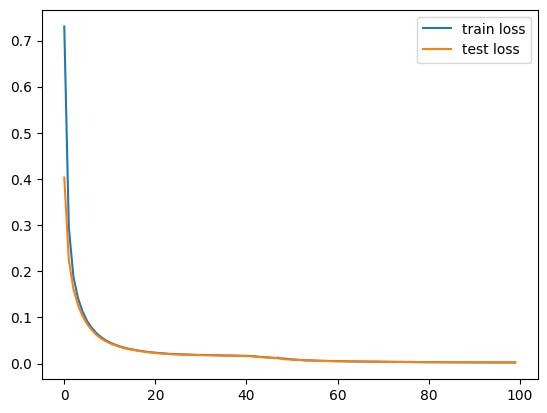

In [7]:
plt.plot(range(len(tr_losses)), tr_losses, label="train loss")
plt.plot(range(epochs), inf_losses, label="test loss")
plt.legend()
plt.show()


### save the model

In [8]:
torch.save(model.state_dict(), MODEL_PTH)
